In [1]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_sbi

In [2]:
%presentation_style

In [3]:
%%capture

%set_random_seed 12

In [4]:
%load_latex_macros


$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\newcommand{\amax}{{\text{argmax}}}$
$\newcommand{\P}{{\mathbb{P}}}$
$\newcommand{\E}{{\mathbb{E}}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\Z}{{\mathbb{Z}}}$
$\newcommand{\N}{{\mathbb{N}}}$
$\newcommand{\C}{{\mathbb{C}}}$
$\newcommand{\abs}[1]{{ \left| #1 \right| }}$
$\newcommand{\simpl}[1]{{\Delta^{#1} }}$


<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">
    <h1>Evaluating simulation-based inference</h1>
</div>

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import torch

from torch import Tensor, log, ones, zeros
from typing import Callable

from tfl_training_sbi.config import (
    default_remote_storage,
    get_config,
    root_dir,
)
from tfl_training_sbi.data_utils import (
    SIRSimulation,
    load_sir_data,
)

storage = default_remote_storage()
c = get_config(reload=True)

# How can we evaluate the performance of SBI?

- neural density estimators are accurate only in the limit of infinite training data
- the posteriors we get are only approximations
- how do we know SBI is reliable? 

# Methods to evaluate the performance of SBI

1) Checking neural network training convergence
    - monitor posterior log-probability of test data pairs $(\theta, x)$ 
2) Posterior predictive checks
    - test whether the inferred parameters $\theta \sim q(\theta | x_o)$ reproduce the observed data $x_o$
3) Calibration checks
    - check whether the uncertainties of the inferred posteriors are well-calibrated 


## 1) Neural network training convergence

- use logging tools like `lightning`, `tensorboard` or `wandb` (weights and biases, wandb.ai) to track training convergence via the validation loss. 
- validation loss: use unseen data simulated from the prior to evaluate the conditional density estimator: 

```python
validation_loss = -net.log_prob(theta, x)  # - log p(theta | x)
```

- stop training when `validation_loss` converges (e.g., no decrease for 20 epochs)
```python
trainer = SNPE().append_simulations(theta, x)
net = trainer.train(validation_fractior=0.2, stop_after_epochs=20)

```
- use `validation_loss` to perform neural architecture search (e.g., for embedding nets)

## 2) Posterior predictive checks

- the posterior characterizes those model parameters that are likely to have generate the observed data $x_o$
- thus, simulating data with inferred parameters should reproduce $x_o$ ($\pm$ simulator noise)
- posterior predictive checks: 
    - simulate data with parameters sampled from the posterior
    - visually or quantitatively compare to $x_o$
    - if they do not match, something is off! 

# Gaussian example

In [6]:
import torch
from torch import eye, ones, zeros
from sbi.inference import SNPE
from sbi.utils import BoxUniform

def simulator(theta):
    return 0.1 * torch.randn_like(theta) + theta

# choose prior
dim = 2
prior = BoxUniform(-ones(dim), ones(dim))

# run simulations
num_simulations = 1000
theta = prior.sample((num_simulations,))
x = simulator(theta)

# train
trainer = SNPE(prior).append_simulations(theta, x)
trainer.train()
posterior = trainer.build_posterior()

 Neural network successfully converged after 148 epochs.

## 1) Check training convergence

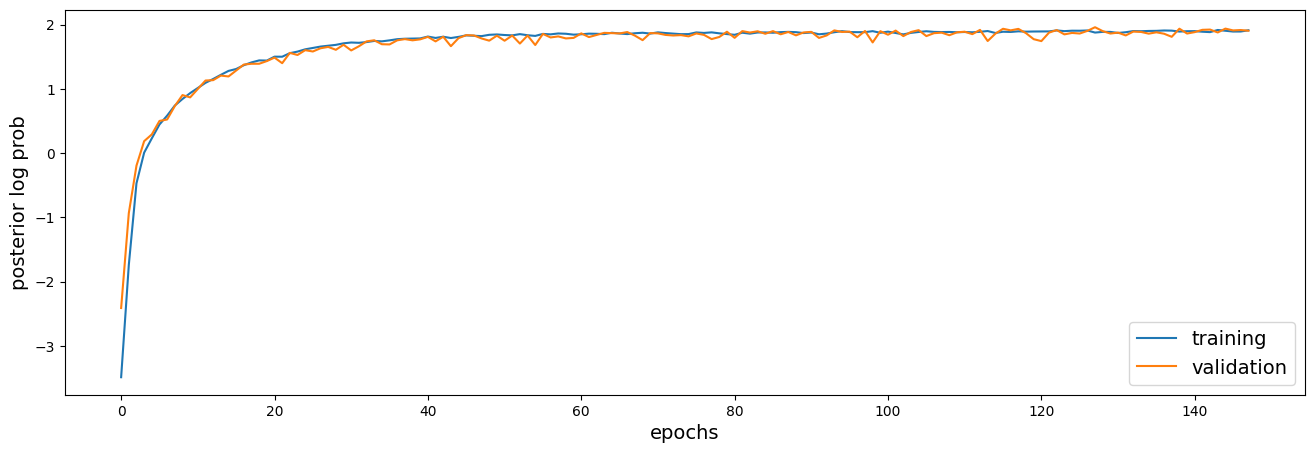

In [7]:
fontsize = 14
plt.figure(figsize=(16, 5))
plt.plot(trainer.summary["training_log_probs"])
plt.plot(trainer.summary["validation_log_probs"])
plt.xlabel("epochs", fontsize=fontsize)
plt.ylabel("posterior log prob", fontsize=fontsize)
plt.legend(["training", "validation"], fontsize=fontsize);

## Visualize posterior

parameter space

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

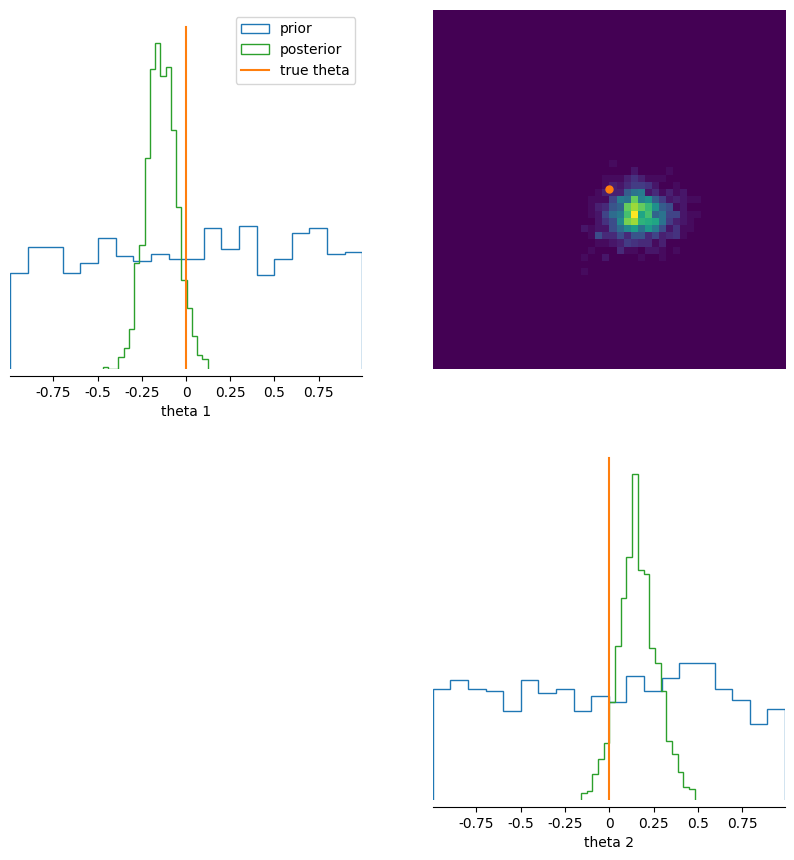

In [10]:
from sbi.analysis import pairplot

theta_o = zeros(dim)
x_o = simulator(theta_o)
num_samples = 1000
posterior_samples = posterior.sample((num_samples,), x=x_o)
pairplot([theta, posterior_samples], points=theta_o, labels=["theta 1", "theta 2"],
         samples_labels=["prior", "posterior"], 
         points_labels=["true theta"],
         legend=True,
         hist_diag=dict(bins=20),
        );

## 2) Posterior predictive check

Note: this is in data space! 

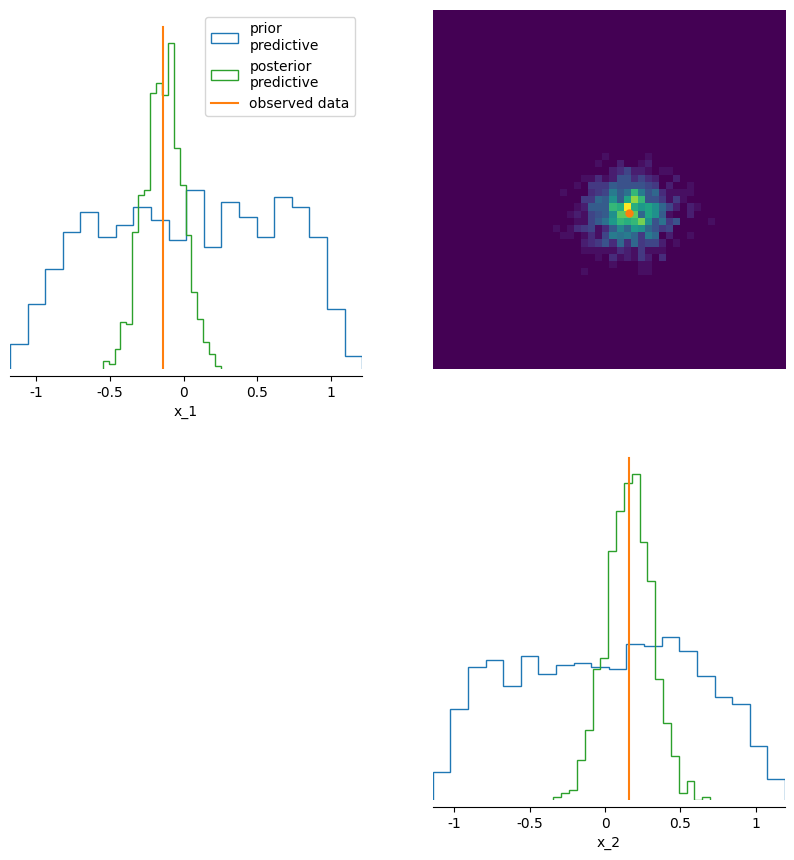

In [11]:
posterior_predictive_samples = simulator(posterior_samples)
pairplot([x, posterior_predictive_samples], points=x_o, labels=["x_1", "x_2"], legend=True,
         samples_labels=["prior\npredictive", "posterior\npredictive"], points_labels=["observed data"], 
         hist_diag=dict(bins=20),
        );

# 3) Posterior calibration checks

- check whether the SBI posterior uncertainties are well-calibrated: whether the posterior is over- or underconfident (on average)
- indirect check: we do not need access to the true posterior
- requirements 
    - access to a set of unseen test data $(\theta, x)$ (~100s)
    - fast inference for each test data point (computationally feasible only for amortized SBI methods)
    - fast posterior sampling (computationally demanding for NLE / NRE). 

### Simulation-based calibration

- Rough idea
  - repeat inference many times with different test $(\theta_i, x_i)$
  - calculate the rank of $\theta_i$ among corresponding posterior samples
  - check whether distribution of ranks is uniform

- Intuition
    - there is uncertainty in the simulator (aleatoric) and in the data (epistemic)
    - posterior is not centered on true parameter
    - but should be somewhere within the posterior (randomly)
    - on average, it should be everywhere within posterior mass (uniform ranks)

- Interpretation
  - the posterior is only if ranks are uniform are uniform (necessary condition)
  - shape of rank-distribution gives insight about mis-calibration
  - can be gamed by setting posterio=prior (it's not a sufficient condition)

<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">Thank you for the attention!</div>